<a href="https://colab.research.google.com/github/keith-golden/gpt2-fake-news/blob/main/Big_Data_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

The spread of online misinformation poses a serious threat to democracies in the 21st century. It erodes trust in public institutions and increases political polarization, weakening the foundation that democratic systems are built upon.

Previous research has shown that machine-learning classifiers can be useful for identifying misinformation, but this work is largely based on fake news written by humans. Although it's safe to assume that the vast majority of the web's fake news has been authored by humans, this will likely change. As machine-learning technologies advance, particularly in the sub-field of *Natural Language Generation* (NLG), it will become increasingly cheap and easy to generate and spread AI-authored misinformation at scale. We suspect this will result in an influx of AI-generated fake news on the web. 

With ML algorithms becoming a predominant tool for mitigating the spread of misinformation, it's critical that we understand how well they perform against AI-authored text. **This is the aim of our project -- to better understand how well current ML tools detect misinformation generated by sophisticated AI, and to observe it's compared performance  on human-authored fake news.** In other words, how well does AI stack up against humans in creating misinformation?

In February 2019, one the of the world's leading AI labs, OpenAI, released a generative text language model known as GPT-2. By priming the model with a few words or phrases such as an article headline, GPT-2 is able to generate coherent paragraphs of text based off the input with high robustness. At the time of release, GPT-2 was the most sophisticated model of its kind (it has since been surpassed by its successor GPT-3).  

To test how well ML classifiers can detect AI-generated fake news compared to human-authored articles, we used a dataset of GPT-2's text outputs published by OpenAI on Github (Note: We would have used GPT-3, but there are restrictions on accessing the API). For samples of human-authored real and fake news we used articles belonging to a dataset on Kaggle. The human-authored articles were individually labeled as Fake or Real based on fact-checking conducted by Poltifact.com.

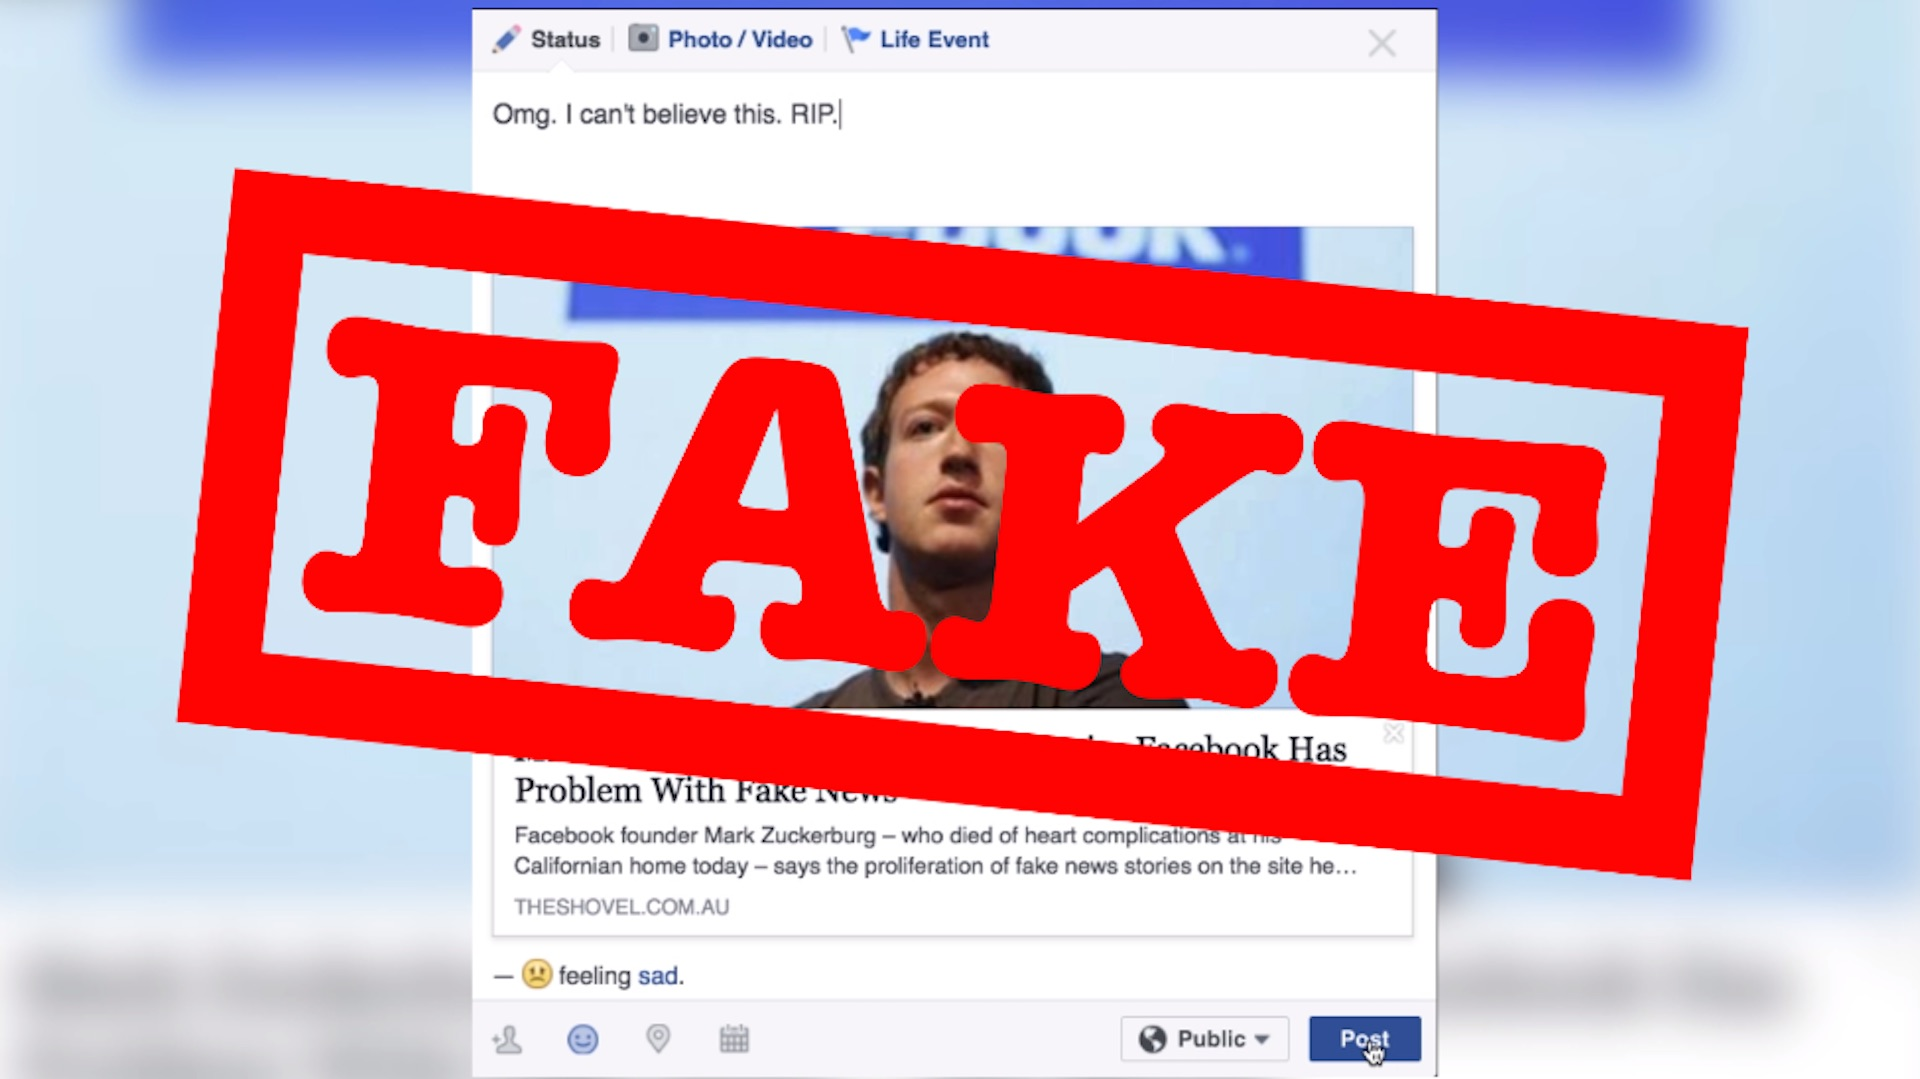



# Data Loading & Pre-Processing

## Downloading AI-generated GPT-2 Data

Dataset is located on github here: https://github.com/openai/gpt-2-output-dataset/blob/master/README.md

The dataset has different outputs (text) generated from the model trained at different strengths:
- 117 million parameters
- 345 million parameters
- 762 million parameters
- 1.542 billion parameters

**We are downloading from the strongest model (1.542 billion parameters) because it produces the most sophisticated text.**

In [ ]:
import os
import sys
import requests
from tqdm import tqdm

subdir = 'data'
if not os.path.exists(subdir):
    os.makedirs(subdir)
subdir = subdir.replace('\\','/') # needed for Windows


# Just downloading outputs from strongest version (xl-1542M)

# The dataset contains train, valid and test sets, but the number of samples
# is so large that we only need the training set (250,000 samples)
filename = 'xl-1542M-k40.train.jsonl'
r = requests.get("https://storage.googleapis.com/gpt-2/output-dataset/v1/" + filename, stream=True)

with open(os.path.join(subdir, filename), 'wb') as f:
    file_size = int(r.headers["content-length"])
    chunk_size = 1000
    with tqdm(ncols=100, desc="Fetching " + filename, total=file_size, unit_scale=True) as pbar:
        # 1k for chunk_size, since Ethernet packet size is around 1500 bytes
        for chunk in r.iter_content(chunk_size=chunk_size):
            f.write(chunk)
            pbar.update(chunk_size)

Fetching xl-1542M-k40.train.jsonl: 748Mit [00:11, 67.1Mit/s]                                        


The result is that we've downloaded a set of outputs (AI-generated text) produced from the 1.5 billion parameter model. The data on Github is split into training, test, and validation set, but since the size of the training set (250k+ samples) is already so much larger than the human-authored articles we will download, we do not need to download the GPT-2 test and validation sets.

In [ ]:
import pandas as pd

In [ ]:
ai_df = pd.read_json('/content/data/xl-1542M-k40.train.jsonl', lines=True)

In [ ]:
# Confirm length is correct (250,000 expected)
print("Number of AI text articles: " + str(len(ai_df)))

Number of AI text articles: 250000


In [ ]:
ai_df.head()

,id,text,length,ended
0,1,"Cops will have to take ""extreme care"" to avoid...",433,True
1,2,The latest edition of the German Football Hall...,715,True
2,3,"Dangerous animals, especially snakes, in a car...",1024,False
3,4,I started my first MLP story way back in 2014 ...,1024,False
4,5,This article is a disambiguation page for The ...,84,True


In [ ]:
# Printing first output
ai_df.iloc[0, 1]

'Cops will have to take "extreme care" to avoid jail-breaking the latest iPhones as the US government will fine manufacturers for breaking its digital security.\n\nApple has been criticised for designing and releasing its latest smartphone without any security measures.\n\nApple has defended the iPhone 6 for carrying out some of its advanced security measures, but will be fined if it continues to fail that test.\n\nThe Federal Communications Commission and FBI will be allowed to fine companies as much as $25,000 (£17,800) for not patching bugs after they are announced.\n\nThe FCC, under a new ruling from president Obama , will allow fines of $1,500 per device over the same "bug bounty".\n\nThere have been multiple hacks into iPhone 6 smartphones this year in the wake of the 2013 revelation that the device could be unlocked with a passcode lock.\n\nHowever, security experts have criticised Apple\'s software and device for not patching its bugs to prevent them becoming the latest weapon 

### **Dropping incomplete AI articles, unneccesary columns** 
The df column "ended" consists of boolean values where True represents the full text generated by the AI model and False represents a text that was cut short before completing.

We are dropping instances where ended==false because those articles terminate mid-sentence. "Real" news articles do not do this, so we want our AI text to match in this respect.

In [ ]:
# Only keep articles where ended == True
ai_df = ai_df[ai_df['ended']==True]

print("# of AI samples after dropping incomplete text: " + str(len(ai_df)))

# of AI samples after dropping incomplete text: 175735


Now we drop the "ended" column since its no longer needed, as well as the "length" and "id" columns.

"Length" represents BPE (Byte Pair Encoding) length which we will not be using.

In [ ]:
# Now dropping the "ended" and "length" columns 
ai_df.drop(labels=['ended', 'length', 'id'], axis=1, inplace=True)

ai_df.head()

,text
0,"Cops will have to take ""extreme care"" to avoid..."
1,The latest edition of the German Football Hall...
4,This article is a disambiguation page for The ...
9,What is it?\n\nIt's a video game that's a comb...
10,Greetings Saviors!We hope you're all well and ...


## Uploading & Pre-Processing Human-Authored Real/Fake News

Manually uploaded files from: https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset/download



In [ ]:
real_df = pd.read_csv('/content/True.csv')
fake_df = pd.read_csv('/content/Fake.csv')

We have WAY more samples of AI-generated text (175k+) compared to our two human-authored groups (Real and Fake). We will limit the number of AI text at a late point to control for over-representation.

In [ ]:
print("# Real articles: " + str(len(real_df)))

print("# Fake articles: " + str(len(fake_df)))

# Real articles: 21417
# Fake articles: 23481


In [ ]:
# Viewing dataframe
real_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
# Dropping title, subject and data columns since we cant use these in AI-text
real_df.drop(labels=['title', 'subject', 'date'], axis=1, inplace=True)
fake_df.drop(labels=['title', 'subject', 'date'], axis=1, inplace=True)

real_df.head()

,text
0,WASHINGTON (Reuters) - The head of a conservat...
1,WASHINGTON (Reuters) - Transgender people will...
2,WASHINGTON (Reuters) - The special counsel inv...
3,WASHINGTON (Reuters) - Trump campaign adviser ...
4,SEATTLE/WASHINGTON (Reuters) - President Donal...


### Removing Reuters

21,378 of the 21,417 Real articles contain "(Reuters)" in them. Only 311 Fake Articles contain this word. 

If we leave this in the text, the algorithms will pick up on this difference and will give us unwarranted high accuracy.

As shown below, most Real articles follow the format of having the bureau location followed by "(Reuters)". Removing this portion of text from both DFs.

In [ ]:
# Real articles that contain "Reuters" in them
real_df[real_df['text'].str.contains("Reuters")]

,text
0,WASHINGTON (Reuters) - The head of a conservat...
1,WASHINGTON (Reuters) - Transgender people will...
2,WASHINGTON (Reuters) - The special counsel inv...
3,WASHINGTON (Reuters) - Trump campaign adviser ...
4,SEATTLE/WASHINGTON (Reuters) - President Donal...
...,...
21412,BRUSSELS (Reuters) - NATO allies on Tuesday we...
21413,"LONDON (Reuters) - LexisNexis, a provider of l..."
21414,MINSK (Reuters) - In the shadow of disused Sov...
21415,MOSCOW (Reuters) - Vatican Secretary of State ...


In [ ]:
# Fake articles that contain "Reuters" in them
fake_df[fake_df['text'].str.contains("Reuters")]

,text
115,Republicans should be downright afraid to try ...
265,"Before departing for Puerto Rico, Donald Trump..."
348,By now you would be more than aware of Preside...
350,Donald Trump has been fundraising like crazy f...
417,"After Hurricane Harvey devastated Houston, Tex..."
...,...
23275,Shawn Helton 21st Century WireAnother active-s...
23308,"Daily Shooter 21st Century WireLast night, a h..."
23344,21st Century Wire says The military industrial...
23359,21st Century Wire says A greater percentage of...


In [ ]:
# Remove 'Reuters) - ' and anything that comes before it
real_df['text'] = real_df['text'].apply(lambda x: x.split('Reuters) - ')[-1])

# Remove 'Reuters' even if it doesnt follow format above
real_df['text'] = real_df['text'].apply(lambda x: x.replace('Reuters', ''))


# Print remaining rows containing Reuters - expecting empty DataFrame
print(real_df[real_df['text'].str.contains("Reuters")])

Empty DataFrame
Columns: [text]
Index: []


In [ ]:
# Repeat for Fake df
fake_df['text'] = fake_df['text'].apply(lambda x: x.split('Reuters) - ')[-1])
fake_df['text'] = fake_df['text'].apply(lambda x: x.replace('Reuters', ''))

# Print remaining rows containing Reuters - expecting empty DataFrame
print(fake_df[fake_df['text'].str.contains("Reuters")])

Empty DataFrame
Columns: [text]
Index: []


### Cleaning unwanted characters

There are few things we want to clean up from the articles:


*   Replace newline characters, "/n", with spaces
*   Replace unix whitespace characters, "\xa0", with spaces
*   Remove http links



In [ ]:
# Examples of text we want to clean

# Contains '\n' 
ai_df.text.iloc[0]

#Contains unicode space '\xa0'
real_df.text.iloc[13]

# Contains https link
fake_df.text.iloc[3]


'On Christmas day, Donald Trump announced that he would  be back to work  the following day, but he is golfing for the fourth day in a row. The former reality show star blasted former President Barack Obama for playing golf and now Trump is on track to outpace the number of golf games his predecessor played.Updated my tracker of Trump s appearances at Trump properties.71 rounds of golf including today s. At this pace, he ll pass Obama s first-term total by July 24 next year. https://t.co/Fg7VacxRtJ pic.twitter.com/5gEMcjQTbH  Philip Bump (@pbump) December 29, 2017 That makes what a Washington Post reporter discovered on Trump s website really weird, but everything about this administration is bizarre AF. The coding contained a reference to Obama and golf:  Unlike Obama, we are working to fix the problem   and not on the golf course.  However, the coding wasn t done correctly.The website of Donald Trump, who has spent several days in a row at the golf course, is coded to serve up the fo

In [ ]:
import re

def clean_text(text):
  """Cleans newline characters, unix whitespace, 
  and http links from text"""

  text = re.sub(r'\n', ' ', text)
  text = re.sub('\xa0', ' ', text)
  cleaned_text = re.sub('(http)(.+?)(?:\s)', ' ', text)   # 'http' followed by text up until space char

  return cleaned_text

In [ ]:
# Before cleaning
# Contains '\n' 
ai_df.text.iloc[0]

# #Contains unicode space '\xa0'
# real_df.text.iloc[13]

# # # Contains https link
# fake_df.text.iloc[3]

'Cops will have to take "extreme care" to avoid jail-breaking the latest iPhones as the US government will fine manufacturers for breaking its digital security.\n\nApple has been criticised for designing and releasing its latest smartphone without any security measures.\n\nApple has defended the iPhone 6 for carrying out some of its advanced security measures, but will be fined if it continues to fail that test.\n\nThe Federal Communications Commission and FBI will be allowed to fine companies as much as $25,000 (£17,800) for not patching bugs after they are announced.\n\nThe FCC, under a new ruling from president Obama , will allow fines of $1,500 per device over the same "bug bounty".\n\nThere have been multiple hacks into iPhone 6 smartphones this year in the wake of the 2013 revelation that the device could be unlocked with a passcode lock.\n\nHowever, security experts have criticised Apple\'s software and device for not patching its bugs to prevent them becoming the latest weapon 

In [ ]:
#After cleaning
clean_text(ai_df.text.iloc[0])

'Cops will have to take "extreme care" to avoid jail-breaking the latest iPhones as the US government will fine manufacturers for breaking its digital security.  Apple has been criticised for designing and releasing its latest smartphone without any security measures.  Apple has defended the iPhone 6 for carrying out some of its advanced security measures, but will be fined if it continues to fail that test.  The Federal Communications Commission and FBI will be allowed to fine companies as much as $25,000 (£17,800) for not patching bugs after they are announced.  The FCC, under a new ruling from president Obama , will allow fines of $1,500 per device over the same "bug bounty".  There have been multiple hacks into iPhone 6 smartphones this year in the wake of the 2013 revelation that the device could be unlocked with a passcode lock.  However, security experts have criticised Apple\'s software and device for not patching its bugs to prevent them becoming the latest weapon in the fight

In [ ]:
# Clean the text on all dfs

df_list = [real_df, fake_df, ai_df]

for df in df_list:
  df['text'] = df['text'].apply(lambda x: clean_text(x))

# EDA & Feature extraction

### Combining the dfs
Here we combine the 3 dfs (real_df, fake_df, and ai_df) into a single dataframe, "articles_df".

A new column, "group", will distinguish between the 3 groups of samples:


*   real = Human-authored articles deemed to be legitimate news
*   fake_hum = Human-authored fake news articles
*   fake_ai = AI-generated fake text articles


In [ ]:
real_df["group"] = "real"
fake_df["group"] = "fake_hum"
ai_df["group"] = "fake_ai"

In [ ]:
# Combining dfs
articles_df = real_df.append([fake_df, ai_df], verify_integrity=True, ignore_index=True)

articles_df

,text,group
0,The head of a conservative Republican faction ...,real
1,Transgender people will be allowed for the fir...,real
2,The special counsel investigation of links bet...,real
3,Trump campaign adviser George Papadopoulos tol...,real
4,President Donald Trump called on the U.S. Post...,real
...,...,...
220628,"""You are like a child and you do not know what...",fake_ai
220629,There are a lot of things that I don't like ab...,fake_ai
220630,Battles Between the English and the Scots The...,fake_ai
220631,Kurt Rambis is the new head coach of the Knick...,fake_ai


### Dropping duplicates
While building our models we noticed unreasonably high accuracy in our classifcation. We found each group has some duplicate samples, particuarly the fake_hum group with 4,841 duplicate entries. 

In [ ]:
# Are there duplicates?

articles_df[articles_df["group"] == 'fake_hum'] # of fake_hum articles: 21226 
len(articles_df[articles_df["group"] == 'fake_hum'].text.unique()) # 16385 unique fake_hum articles


articles_df[articles_df["group"] == 'real'] # of real articles: 20253 
len(articles_df[articles_df["group"] == 'real'].text.unique()) # 20043 unique real articles


articles_df[articles_df["group"] == 'fake_ai'] # of ai articles: 165190 
len(articles_df[articles_df["group"] == 'fake_ai'].text.unique()) # 165121 unique ai articles

# Yes, all 3 groups have some duplicates, particularly the fake_hum group with 4841 duplicate articles.
# fake_ai and real each have < 250 duplicates
# 5,120 duplicate articles total

16306

In [ ]:
# Dropping rows with duplicate articles
articles_df.drop_duplicates(subset=['text'], inplace=True, ignore_index=True)

articles_df


,text,group
0,The head of a conservative Republican faction ...,real
1,Transgender people will be allowed for the fir...,real
2,The special counsel investigation of links bet...,real
3,Trump campaign adviser George Papadopoulos tol...,real
4,President Donald Trump called on the U.S. Post...,real
...,...,...
214253,"""You are like a child and you do not know what...",fake_ai
214254,There are a lot of things that I don't like ab...,fake_ai
214255,Battles Between the English and the Scots The...,fake_ai
214256,Kurt Rambis is the new head coach of the Knick...,fake_ai


## Article length
In this section we control for the large disparities in article length between group by dropping articles that are particularly short or long.

In [ ]:
# Create column for article length

articles_df['length'] = articles_df['text'].apply(lambda x: len(x))

### Dropping short articles
Below we drop any articles containing less than 400 characters. This threshold is somewhat arbitrary, however, short bodies of text decrease accuracy in classification, and an article below 400 characters is arguably too short to be considered a news article in the real world.

Additionally, since we are working with limited data, this threshold allows us to retain 20,000+ samples for each group

In [ ]:
# Viewing the number of articles for each group

print("# of articles for real: " + str(len(articles_df[articles_df['group'] == 'real'])))
print("# of articles for fake_hum: " + str(len(articles_df[articles_df['group'] == 'fake_hum'])))
print("# of articles for fake_ai: " + str(len(articles_df[articles_df['group'] == 'fake_ai'])))

# of articles for real: 21191
# of articles for fake_hum: 17454
# of articles for fake_ai: 175613


In [ ]:
# Drop short articles
articles_df.drop(articles_df[articles_df['length'] < 400].index, inplace=True)

# Reset index
articles_df.reset_index(drop=True, inplace=True)

# New number of articles
print("# of articles for real: " + str(len(articles_df[articles_df['group'] == 'real'])))
print("# of articles for fake_hum: " + str(len(articles_df[articles_df['group'] == 'fake_hum'])))
print("# of articles for fake_ai: " + str(len(articles_df[articles_df['group'] == 'fake_ai'])))

# of articles for real: 20043
# of articles for fake_hum: 16385
# of articles for fake_ai: 165121


Now we will plot the article lengths to see the differences between groups.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 1.0, 'Article Length by Group')

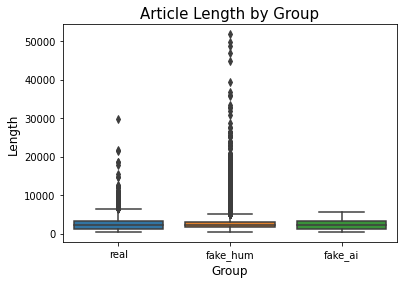

In [ ]:
sns.boxplot(x='group', y='length', data=articles_df)

plt.xlabel("Group", fontsize= 12)
plt.ylabel("Length", fontsize= 12)
plt.title("Article Length by Group", fontsize=15)

### Crop long articles
Observing the plot above, we can see there is a long tail for article length in the real and fake_hum groups. Both of these group have a minority of articles that are relatively long compared to fake_ai.

Below we can see the longest fake_ai article is 5711 characters. Since there are many real and fake_hum articles that are much longer than this, we will trim all real and fake_hum articles that are greater than 5711 characters. 

We are doing this to control for the disparity in lengths between groups.

In [ ]:
# Longest fake_ai article
articles_df[articles_df.group == 'fake_ai'].length.max()

5711

In [ ]:
# All articles that are too long
articles_df[articles_df.length > 5711]

,text,group,length
20,The U.S. Justice Department has issued new gui...,real,5746
32,"In the Fox & Hound sports bar, next to a shopp...",real,6679
48,The Republican-controlled U.S. House of Repres...,real,5811
63,The two Democratic candidates running for gove...,real,8133
68,The U.S. House of Representatives gave final a...,real,7006
...,...,...,...
36420,Patrick Henningsen 21st Century WireRemember ...,fake_hum,25065
36423,21st Century Wire says All the world s a stage...,fake_hum,7359
36424,Randy Johnson 21st Century WireThe majority ...,fake_hum,26275
36426,21st Century Wire says A new front has just op...,fake_hum,20651


In [ ]:
# importing word_tokenize to use in function below
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

The function crop_article() takes a threshold that we will set to 5711 (the length of the longest fake_ai text). The function crops any texts longer than 5711 characters so that they terminate at the end of the sentence at which the 5711 limit is reached.

We do this rather than cropping all articles at the 5711 limit so that articles do not terminate in the middle of a word or sentence.



In [ ]:
def article_crop(article, char_limit):
  """Given a DataFrame row that contains a 'text' column and a character limit, this crops
      the text to end at the sentence after the character limit is reached

  Params
  - row: a row of a Dataframe that contains 'text' column
  - char_limit: int, once text reaches this limit, the current sentence will become the final sentence in the text
  """


  # If text is longer than char limit
  if len(article) > char_limit:

    # Split text into two groups, before and after the character limit
    before_limit = article[: char_limit]
    after_limit = article[char_limit : ]

    # If after_limit contains more than just whitespace (check is needed b/c calling sent_tokenize()[0] on whitespace will fail)
    if len(nltk.sent_tokenize(after_limit)) > 0:

      sent_after_limit = nltk.sent_tokenize(after_limit)[0] # Take 1st sentence after char_limit
      
      new_text = before_limit + sent_after_limit
      return new_text

    # In this case, chars after char_limit only contain whitespace
    else:
      return before_limit

  else:
    return article

In [ ]:
# Shows where data will be cut off at the limit
articles_df.text.iloc[63][5400:5711] 

' Dan Cantor, national chairman of the Working Families Party.      MoveOn, whose recent endorsement of Abrams marked its first in a 2018 governor’s race, said it would mobilize its 125,000 Georgia members as volunteers for her campaign.      Democracy for America is similarly engaging nearly 35,000 members in '

In [ ]:
# Shows the final sentence being completed using article_crop()
article_crop(articles_df.text.iloc[63], 5711)[5400:] 

' Dan Cantor, national chairman of the Working Families Party.      MoveOn, whose recent endorsement of Abrams marked its first in a 2018 governor’s race, said it would mobilize its 125,000 Georgia members as volunteers for her campaign.      Democracy for America is similarly engaging nearly 35,000 members in the state.'

In [ ]:
# For texts longer than 5711 chars (the longest AI text), crop when the sentence at 5711 chars ends
articles_df['text'] = articles_df.text.apply(lambda x: article_crop(x, 5711))
articles_df

,text,group,length
0,The head of a conservative Republican faction ...,real,4636
1,Transgender people will be allowed for the fir...,real,4054
2,The special counsel investigation of links bet...,real,2766
3,Trump campaign adviser George Papadopoulos tol...,real,2431
4,President Donald Trump called on the U.S. Post...,real,5173
...,...,...,...
201544,Rise: The Dawn of Justice: $3-4 per copy Rise...,fake_ai,2154
201545,There are a lot of things that I don't like ab...,fake_ai,3675
201546,Battles Between the English and the Scots The...,fake_ai,3650
201547,Kurt Rambis is the new head coach of the Knick...,fake_ai,1838


Text(0.5, 1.0, 'Article Length by Group')

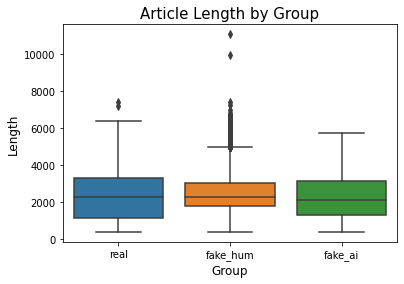

In [ ]:
# Recomputing article lengths after crops
articles_df['length'] = articles_df['text'].apply(lambda x: len(x))


# Viewing new article lengths after crops
sns.boxplot(x='group', y='length', data=articles_df)

plt.xlabel("Group", fontsize= 12)
plt.ylabel("Length", fontsize= 12)
plt.title("Article Length by Group", fontsize=15)

As we see below and will continue to see in the next section, due to the style in which some of the articles are written, sent_tokenize() does not always parse sentences correctly.

In the two texts shown below, the articles describe a series of events that are separated by colons or semicolons. sent_tokenize() treats these as long sentences rather than parsing into smaller tokens.

Fortunately, only a small number of articles are affected by this.

In [ ]:
# articles that are still really long
articles_df[articles_df.length > 8000]

,text,group,length
22681,"In another of Donald Trump s whine rests, the ...",fake_hum,9912
35379,Fundamental transformation Obama style Henry C...,fake_hum,11049


In [ ]:
# Last part of articles that are still really long
# Both are sentences separated by colons and semicolons
articles_df.text.iloc[22681][-2500:]
articles_df.text.iloc[35379][-2500:]

'g offense; Southern District of Alabama Sentence: 180 months  imprisonment; eight years  supervised release (March 8, 2007) Commutation Grant: Prison sentence commuted to expire on July 28, 2016, and supervised release term commuted to four years of supervised release.Isadore Gennings   Cincinnati, OH Offense: Conspiracy to distribute cocaine; interstate travel in aid of racketeering enterprises; possession with intent to distribute in excess of five kilograms of cocaine; Southern District of Ohio Sentence: 240 months  imprisonment; 10 years  supervised release (March 14, 2002) Commutation Grant: Prison sentence commuted to expire on July 28, 2016, and supervised release term commuted to five years of supervised release.Lamont Durville Glass   Knoxville, TN Offense: Possession with intent to distribute cocaine base; felon in possession of a firearm; Eastern District of Tennessee Sentence: 262 months  imprisonment; eight years  supervised release (January 9, 1998) Commutation Grant: Pr

## Sentence tokenization 

For each article we are creating a list of lists containing individual sentences. We will use these as features for our ML models and to compute average words per sentence. 

In [ ]:
# Tokenize sentences
articles_df['sentences'] = articles_df['text'].apply(lambda x: nltk.sent_tokenize(x))

articles_df

,text,group,length,sentences
0,The head of a conservative Republican faction ...,real,4636,[The head of a conservative Republican faction...
1,Transgender people will be allowed for the fir...,real,4054,[Transgender people will be allowed for the fi...
2,The special counsel investigation of links bet...,real,2766,[The special counsel investigation of links be...
3,Trump campaign adviser George Papadopoulos tol...,real,2431,[Trump campaign adviser George Papadopoulos to...
4,President Donald Trump called on the U.S. Post...,real,5173,"[President Donald Trump called on the U.S., Po..."
...,...,...,...,...
201544,Rise: The Dawn of Justice: $3-4 per copy Rise...,fake_ai,2154,[Rise: The Dawn of Justice: $3-4 per copy Ris...
201545,There are a lot of things that I don't like ab...,fake_ai,3675,[There are a lot of things that I don't like a...
201546,Battles Between the English and the Scots The...,fake_ai,3650,[Battles Between the English and the Scots Th...
201547,Kurt Rambis is the new head coach of the Knick...,fake_ai,1838,[Kurt Rambis is the new head coach of the Knic...


## Average words per sentence 
We apply the function defined below to each article to create a column of average words per sentence for each sample

In [ ]:
def avg_words_per_sent(text):
  """Feed a list of sentences (param:text) and 
  returns the average number of words per sentence"""
  
  num_words_list = [] # List of word count per sentence
  
  for sent in range(len(text)):

    # Number of words in a sentence, excludes punctuation
    num_words = len([word for word in word_tokenize(text[sent]) if word.isalnum()])
    
    # Add number of words for sentence to the list
    num_words_list.append(num_words)

  
  # Compute the average
  avg_word_per_sentences = sum(num_words_list) / len(num_words_list)

  return avg_word_per_sentences


In [ ]:
# Compute avg words per sentence for each column
articles_df['words_per_sent'] = articles_df['sentences'].apply(lambda x: avg_words_per_sent(x))

In [ ]:
articles_df.head()

,text,group,length,sentences,words_per_sent
0,The head of a conservative Republican faction ...,real,4636,[The head of a conservative Republican faction...,24.700000
1,Transgender people will be allowed for the fir...,real,4054,[Transgender people will be allowed for the fi...,29.190476
2,The special counsel investigation of links bet...,real,2766,[The special counsel investigation of links be...,26.882353
3,Trump campaign adviser George Papadopoulos tol...,real,2431,[Trump campaign adviser George Papadopoulos to...,23.312500
4,President Donald Trump called on the U.S. Post...,real,5173,"[President Donald Trump called on the U.S., Po...",20.850000


### Visualizing avg words per sentence

Text(0.5, 1.0, 'Avg words per sentence by group')

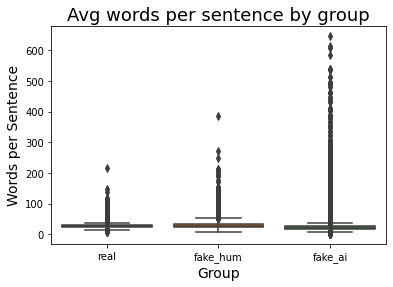

In [ ]:
sns.boxplot(x='group', y='words_per_sent', data=articles_df)

plt.xlabel("Group", fontsize= 14)
plt.ylabel("Words per Sentence", fontsize= 14)
plt.title("Avg words per sentence by group", fontsize=18)

### Dropping Outliers - Avg words per sentence

One limitation of our project is that the contents of GPT-2's outputs are not limited to text about news-related topics.

The majority of the data that GPT-2 was trained on was news articles on the web, and so a majority of its outputs are news-related content. However, GPT-2 was also trained on non-news text from the web, and so some of its outputs are not news-related.

When we took a closer look at the fake_ai articles with a particularly high average words per sentence, we noticed that they seem to be almost entirely non-news subjects. Many seem to be song lyrics generated by GPT-2, or look like text scraped from a Youtube page. The high average is caused by sent_tokenizer() splitting these texts into a relatively few number of sentences.

Since we have nearly 10x the number of AI articles compared to the other two groups, we can afford to drop these outliers. Dropping them will also give us the desirable effects of: 
1.   Having a higher proportion of news content in our fake_ai group
2.   Reducing the disparity of average words/sentence between groups

In [ ]:
# AI text higher than 100 words per sentence
articles_df[(articles_df['words_per_sent'] > 100) & (articles_df['group'] == "fake_ai")]

,text,group,length,sentences,words_per_sent
36773,"PURCHASE TICKETS Tuesday, May 3 – The Last Ki...",fake_ai,1780,"[PURCHASE TICKETS Tuesday, May 3 – The Last K...",303.000000
36986,Forum Jump User Control Panel Private Message...,fake_ai,946,[Forum Jump User Control Panel Private Messag...,122.000000
37289,The first season of HBO's Girls has been one l...,fake_ai,5048,[The first season of HBO's Girls has been one ...,274.666667
37398,On this episode we talk to writer/director and...,fake_ai,833,[On this episode we talk to writer/director an...,136.000000
37684,(1) A person commits criminal trespass in the ...,fake_ai,803,[(1) A person commits criminal trespass in the...,139.000000
...,...,...,...,...,...
199411,1 Clean Episode 20: The Biggest Deal In The Hi...,fake_ai,2796,[1 Clean Episode 20: The Biggest Deal In The H...,260.000000
199911,1st Round 1st Overall 1st Team 2nd Team 2nd Te...,fake_ai,1225,[1st Round 1st Overall 1st Team 2nd Team 2nd T...,178.000000
200086,1 of 11 View Caption Steve Griffin | BDN Stev...,fake_ai,785,[1 of 11 View Caption Steve Griffin | BDN Ste...,121.000000
200394,The following is a list of items that make goo...,fake_ai,5641,[The following is a list of items that make go...,166.400000


In [ ]:
# AI-generated lyric example
articles_df.text.iloc[43307]

"Lyrics  I've seen you stand  I've heard you call  It's been so hard, you've left me, goodbye  You made me smile  I saw you stand all night long  You looked as if you were going right to sleep  And I know you wouldn't lie to me   I know you wouldn't lie to me, tell me you didn't want to see me  You couldn't hide your smile when I was here  You had the courage of what you were gonna do  And I know you wouldn't lie to me, tell me you wouldn't  I've told you so many times  Laugh, cry, love, hurt  I've seen you stand with me  Laugh, cry, love, hurt  I've seen you stand, I've heard you call, let's go  You said 'we,' I said 'me'  It was in the middle of the night  We were standing on edge together, my heart is breaking  I saw it all before  You told me you loved me every time  And you said goodbye  And I know you wouldn't lie to me, tell me it wasn't true  You said you would wait by the phone  For you  I've told you so many times  Laugh, cry, love, hurt  I've seen you stand, I've heard you c

In [ ]:
# AI-generated youtube page example
articles_df.text.iloc[49514]

'Categories  Categories Select Category 90 Days (9) All Access Passes (3) Books (1) Briefing for Authors (2) Briefing for Authors and Publishers (10) Calendars (1) Conferences (1) Content and Tools for Authors (20) Editing Tools (1) Events (1) Event Tickets (1) Finance and Operations Team (8) Event Planning (1) Fundraising (16) Graphic Design (1) Hacks/Theory/Techniques (3) Helpdesk Support (3) Interviews/Conversations (1) Jokes/Laughter (1) Life Hacks (3) Maintenance, Troubleshooting, & Administration (1) Marketing (1) Miscellaneous (1) Open Source Programs and Communities (1) Planning (3) Press Releases (1) Publishing (16) Publishing Events/Resources (1) Publishing Tools (17) Proofreading (1) Report Writing (1) Research (1) Sales (3) Sponsorship Opportunities (1) Software (3) Support (2) Support Services (1) Software Documentation (1) Teaching (1) Training (1) Technical Support (5) Uncategorized (25) Video Tutorials (2) Writing Books (7)  Archives Archives Select Month September 2018

There were also a small number of human-authored texts (real and fake_hum) with a relatively high average words per sentence.

In [ ]:
# Human authored text higher than 100 words per sentence
articles_df[(articles_df['words_per_sent'] > 100) & (articles_df['group'] != "fake_ai")]

,text,group,length,sentences,words_per_sent
639,"Attorneys representing Mike Flynn, a former ai...",real,759,"[Attorneys representing Mike Flynn, a former a...",116.000000
3553,U.S. Defense Secretary Jim Mattis said he had ...,real,647,[U.S. Defense Secretary Jim Mattis said he had...,101.000000
5631,President Donald Trump on Friday said he was l...,real,1311,[President Donald Trump on Friday said he was ...,109.500000
6364,The following are people mentioned as contende...,real,4161,[The following are people mentioned as contend...,113.200000
6407,The following are people mentioned as contende...,real,4269,[The following are people mentioned as contend...,116.600000
...,...,...,...,...,...
36288,21st Century Wire says What is wrong with Chri...,fake_hum,787,[21st Century Wire says What is wrong with Chr...,133.000000
36295,21st Century Wire says It is not looking good ...,fake_hum,1099,[21st Century Wire says It is not looking good...,176.000000
36310,21st Century Wire says The FBI is walking a ve...,fake_hum,2048,[21st Century Wire says The FBI is walking a v...,110.666667
36311,21st Century Wire says This is the news that t...,fake_hum,1615,[21st Century Wire says This is the news that ...,248.000000


When we took a closer look, the high average for these outliers appears to be due to the nature of the particular articles.

Articles describing a timeline had a particularly high average. As mentioned in the "Crop long articles" section, they contain colons or semi-colons for each event described in the timeline. sent_tokenize() recognizes this as a single sentence, leading to a particularly high average.

These outliers also included articles that were written without a space after the period ending a sentence. Again, sent_tokenize() will not parse these into individual sentences, leading to high averages.

In [ ]:
# fake_hum article without space between periods
articles_df.sentences.iloc[36311] 

['21st Century Wire says This is the news that the elite political establishment did not want to hear.Watch a video of this report here:A new poll by Rasmussen Reports has Donald Trump beating Hillary Clinton by two points in a head-to-head matchup.Trump comes in at 41% with Clinton trailing behind with 39%.15% of respondents would prefer some other candidate, while 5% were undecided.Last week, Rasmussen ran the same poll and the candidates were evenly split with 38% each.Other polls have suggested that Trump has no chance of beating Hillary, but this latest development certainly brings those conclusions into question.The elite political establishment class is definitely going to be worried by this news, and the ridiculous attacks levelled against Trump may be about to reach new heights.Most worrying for those elites is the thought of America getting along with other countries, something that Trump has explicitly stated he wants to do as president.This means an end to foreign adventuri

We decided to drop all articles with a high average number of words per sentence (> than 100).

The majority of samples that fall into this group are fake_ai text about non-news related topics. This will increase the proportion of news in our fake_ai set.

87 human-authored articles were also dropped as a result, but since this is a small number of articles and they are composed of text written in unconventional formatting, we are fine with dropping them.

In [ ]:
# Dropping articles with 100+ average words per sentence
articles_df.drop(articles_df[articles_df['words_per_sent'] > 100].index, inplace=True)

# Reset index
articles_df.reset_index(drop=True, inplace=True)

print("New count of articles")
print("# of articles for real: " + str(len(articles_df[articles_df['group'] == 'real'])))
print("# of articles for fake_hum: " + str(len(articles_df[articles_df['group'] == 'fake_hum'])))
print("# of articles for fake_ai: " + str(len(articles_df[articles_df['group'] == 'fake_ai'])))

New count of articles
# of articles for real: 20034
# of articles for fake_hum: 16307
# of articles for fake_ai: 164697


We can see in the two plots below that the disparity between groups has been significantly reduced.

Text(0.5, 1.0, 'Avg words per sentence by group')

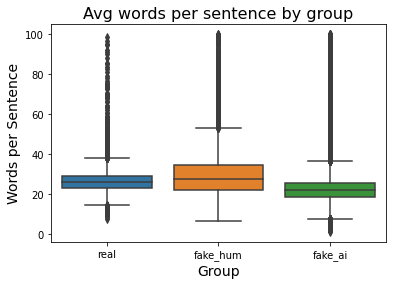

In [ ]:
# Replotting avg words per sentence
sns.boxplot(x='group', y='words_per_sent', data=articles_df)

plt.xlabel("Group", fontsize= 14)
plt.ylabel("Words per Sentence", fontsize= 14)
plt.title("Avg words per sentence by group", fontsize=16)

Text(0.5, 1.0, 'Distribution of avg. words/sentence by group')

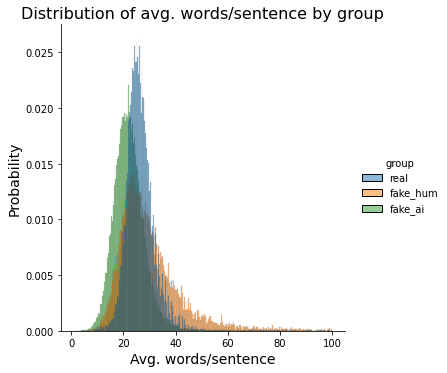

In [ ]:
# Plotting probability distribution due to uneven # of samples between groups
sns.displot(articles_df, x='words_per_sent', hue='group', stat='probability', common_norm=False)

plt.ylabel("Probability", fontsize= 14)
plt.xlabel("Avg. words/sentence", fontsize= 14)
plt.title("Distribution of avg. words/sentence by group", fontsize=16)

## Lowercasing text
We will use this column later on when controlling for differences in word frequencies between groups

In [ ]:
# Create column of lowercase text
articles_df['text_lower'] = articles_df['text'].apply(lambda x: x.lower())

articles_df.head()

,text,group,length,sentences,words_per_sent,text_lower
0,The head of a conservative Republican faction ...,real,4636,[The head of a conservative Republican faction...,24.700000,the head of a conservative republican faction ...
1,Transgender people will be allowed for the fir...,real,4054,[Transgender people will be allowed for the fi...,29.190476,transgender people will be allowed for the fir...
2,The special counsel investigation of links bet...,real,2766,[The special counsel investigation of links be...,26.882353,the special counsel investigation of links bet...
3,Trump campaign adviser George Papadopoulos tol...,real,2431,[Trump campaign adviser George Papadopoulos to...,23.312500,trump campaign adviser george papadopoulos tol...
4,President Donald Trump called on the U.S. Post...,real,5173,"[President Donald Trump called on the U.S., Po...",20.850000,president donald trump called on the u.s. post...


## Word frequencies between groups
In this section we explored the differences in the most common words between groups. 

We noticed a lot of overlap between the two human-authored groups and much less overlap when compared to the AI text.

Finally, we construct an additonal method for filtering out and dropping non-news related AI text.

In [ ]:
from nltk.corpus import stopwords
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

stopwords = set(stopwords.words('english')) 

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We create a function that tokenizes text into words and removes stop words. 

In [ ]:
def tokenize_text(article):
  """ take a text string and
  - tokenizes words
  - lowers case
  - removes stopwords
  - remove non alpha tokens

  :param article_list: list of strings
  :return: list of cleaned text
  """

  tok_text = nltk.word_tokenize(article)
  tok_text = [word.lower() for word in tok_text]
  tok_text = [word for word in tok_text if word not in stopwords]
  tok_text = [word for word in tok_text if word.isalpha()]
  

  return tok_text

Now we create a list of text articles for each group and apply our tokenize_text() to each list.

Each of the 3 results are a list of lists containing words, so we flatten them into 3 lists of words



In [ ]:
# Create a list of text articles for each group
real_text_list = list(articles_df.text[articles_df.group == "real"]) 
fakehum_text_list= list(articles_df.text[articles_df.group == "fake_hum"])
ai_text_list = list(articles_df.text[articles_df.group == "fake_ai"])


# Tokenize and clean the lists from stopwords
# each result is list of lists containing words for each article
real_word_list = [tokenize_text(article) for article in real_text_list] 
fakehum_word_list = [tokenize_text(article) for article in fakehum_text_list] 
ai_word_list = [tokenize_text(article) for article in ai_text_list] 


#flatten the list of lists into a single list of words
flat_real_word_list = [word for article in real_word_list for word in article]
flat_fakehum_word_list = [word for article in fakehum_word_list for word in article]
flat_ai_word_list = [word for article in ai_word_list for word in article]

### Most Common Words
Using the flat lists of words for each group that we created above, we use Counters to count the 50 most common words in each group.

In [ ]:
from collections import Counter

# 50 most common words for real
real_cnt = Counter(flat_real_word_list)
real_most_common = real_cnt.most_common(50)

# Show top 30
real_most_common[:30]

[('said', 94947),
 ('trump', 52120),
 ('would', 30469),
 ('president', 25176),
 ('state', 18991),
 ('government', 17660),
 ('states', 15913),
 ('house', 15730),
 ('also', 15396),
 ('new', 15353),
 ('republican', 14780),
 ('united', 14775),
 ('people', 14528),
 ('told', 13637),
 ('could', 13229),
 ('last', 12240),
 ('one', 12148),
 ('party', 12059),
 ('two', 11185),
 ('election', 11148),
 ('year', 10624),
 ('campaign', 10233),
 ('former', 10122),
 ('donald', 9994),
 ('security', 9688),
 ('percent', 9679),
 ('north', 9384),
 ('clinton', 9222),
 ('court', 9085),
 ('white', 8902)]

In [ ]:
# 50 most common words for fake_hum
fakehum_cnt = Counter(flat_fakehum_word_list)
fakehum_most_common = fakehum_cnt.most_common(50)

# Show top 30
fakehum_most_common[:30]

[('trump', 62411),
 ('said', 22051),
 ('people', 19781),
 ('president', 18432),
 ('would', 17100),
 ('one', 16460),
 ('donald', 14556),
 ('like', 13330),
 ('obama', 12119),
 ('clinton', 11765),
 ('even', 10476),
 ('also', 10359),
 ('via', 9960),
 ('white', 9553),
 ('new', 9473),
 ('time', 9345),
 ('news', 9162),
 ('image', 9010),
 ('hillary', 8974),
 ('us', 8223),
 ('get', 8178),
 ('state', 8132),
 ('campaign', 7978),
 ('know', 7959),
 ('going', 7667),
 ('house', 7617),
 ('republican', 7511),
 ('america', 7181),
 ('could', 7172),
 ('first', 6933)]

In [ ]:
# 50 most common words for ai
ai_cnt = Counter(flat_ai_word_list)
ai_most_common = ai_cnt.most_common(50)

# Show top 30
ai_most_common[:30]

[('said', 322637),
 ('new', 207829),
 ('also', 173136),
 ('one', 165536),
 ('would', 164123),
 ('people', 159626),
 ('first', 111802),
 ('time', 110423),
 ('get', 100370),
 ('like', 98788),
 ('make', 95227),
 ('could', 90304),
 ('two', 88930),
 ('government', 84623),
 ('us', 81396),
 ('year', 76372),
 ('last', 73249),
 ('state', 73188),
 ('police', 72901),
 ('going', 70961),
 ('game', 69158),
 ('use', 68580),
 ('trump', 68485),
 ('may', 67738),
 ('many', 66074),
 ('way', 65811),
 ('years', 65482),
 ('see', 65451),
 ('world', 65355),
 ('want', 64943)]

### Word Clouds
By viewing the lists of the 20 most common words for each group, we can see high overlap between the two human-authored groups (real and fake_hum) and less overlap with the AI text.

Visualizing the word clouds below makes this difference more clear.

In [ ]:
from wordcloud import WordCloud

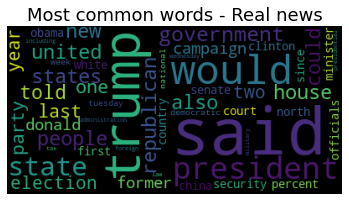

In [ ]:
real_wordcloud = WordCloud(background_color="black", max_words=50).generate_from_frequencies(real_cnt)
plt.imshow(real_wordcloud)
plt.axis("off")
plt.title("Most common words - Real news", fontsize=18)
plt.show()

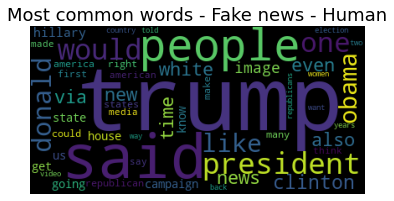

In [ ]:
fakehum_wordcloud = WordCloud(background_color="black", max_words=50).generate_from_frequencies(fakehum_cnt)
plt.imshow(fakehum_wordcloud)
plt.axis("off")
plt.title("Most common words - Fake news - Human", fontsize=18)
plt.show()

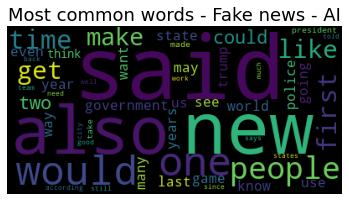

In [ ]:
ai_wordcloud = WordCloud(background_color="black", max_words=50).generate_from_frequencies(ai_cnt)
plt.imshow(ai_wordcloud)
plt.axis("off")
plt.title("Most common words - Fake news - AI", fontsize=18)
plt.show()

### Interpreting and correcting for differences between groups
From looking at the word clouds and lists of most common words we can see that the two human-authored groups contain a higher frequency of political or news-oriented words. Notice differences in words like "trump", "president", "obama", and "election".

Some words like "said" and "trump" are highly represented in all 3 groups. 

The AI text had relatively fewer politically-related words in its most common word list. Again, this is due to GPT-2 not being trained exclusively on news articles -- a subset of its training data contained non-news contents.

In a previous section we reduced this disparity to some extent by dropping articles averaging 100+ words per sentence -- the majority of those dropped were AI articles that did not follow a typical news article's sentence structure (such as song lyrics or YouTube pages). 

In this section, we take further action to reduce the AI's non-news content by:
1.   Creating two lists of the 50 most common words for both of the human-authored groups.
2.   Combining these two lists into a unique set of words - "human_words".
3.  Tagging human_words with parts of speech, and keeping the nouns ONLY -- the result is a list of newsworthy nouns.
4. Dropping any nouns that we deem to be not news-related.
5. Dropping all AI articles from our dataframe that do not contain ANY of the news-worthy nouns. 



Below we create a list of the 50 most common words in real and fake_hum and combine them into a unique set.

In [ ]:
real_words = []
for i in range(len(real_most_common)):
  # Add the word, not the frequency count
  real_words.append(real_most_common[i][0])

# List of most 50 common words in real
real_words



fake_words = []
for i in range(len(fakehum_most_common)):
  # Add the word, not the frequency count
  fake_words.append(fakehum_most_common[i][0])

# List of most 50 common words in fake
fake_words

['trump',
 'said',
 'people',
 'president',
 'would',
 'one',
 'donald',
 'like',
 'obama',
 'clinton',
 'even',
 'also',
 'via',
 'white',
 'new',
 'time',
 'news',
 'image',
 'hillary',
 'us',
 'get',
 'state',
 'campaign',
 'know',
 'going',
 'house',
 'republican',
 'america',
 'could',
 'first',
 'make',
 'right',
 'many',
 'states',
 'american',
 'media',
 'say',
 'think',
 'made',
 'country',
 'way',
 'republicans',
 'told',
 'video',
 'back',
 'election',
 'women',
 'years',
 'two',
 'want']

In [ ]:
# Create set from the 50 most common words from both human-authored groups
human_words = set(real_words + fake_words)

print(len(human_words))
print("")
print(human_words)

77

{'donald', 'republican', 'time', 'military', 'state', 'people', 'president', 'including', 'even', 'white', 'minister', 'administration', 'campaign', 'say', 'want', 'house', 'like', 'get', 'could', 'year', 'security', 'new', 'obama', 'first', 'since', 'also', 'image', 'right', 'way', 'presidential', 'china', 'video', 'hillary', 'court', 'democratic', 'officials', 'week', 'united', 'trump', 'law', 'tax', 'via', 'america', 'last', 'party', 'us', 'country', 'told', 'two', 'make', 'back', 'government', 'media', 'national', 'percent', 'former', 'know', 'north', 'one', 'tuesday', 'american', 'think', 'women', 'years', 'news', 'states', 'going', 'many', 'would', 'senate', 'made', 'election', 'wednesday', 'said', 'foreign', 'republicans', 'clinton'}


In [ ]:
# Tag most common human-authored words with parts of speech
nltk.pos_tag(human_words)

[('donald', 'JJ'),
 ('republican', 'JJ'),
 ('time', 'NN'),
 ('military', 'JJ'),
 ('state', 'NN'),
 ('people', 'NNS'),
 ('president', 'NN'),
 ('including', 'VBG'),
 ('even', 'RB'),
 ('white', 'JJ'),
 ('minister', 'NN'),
 ('administration', 'NN'),
 ('campaign', 'NN'),
 ('say', 'VBP'),
 ('want', 'VBP'),
 ('house', 'NN'),
 ('like', 'IN'),
 ('get', 'NN'),
 ('could', 'MD'),
 ('year', 'NN'),
 ('security', 'NN'),
 ('new', 'JJ'),
 ('obama', 'NN'),
 ('first', 'RB'),
 ('since', 'IN'),
 ('also', 'RB'),
 ('image', 'NN'),
 ('right', 'JJ'),
 ('way', 'NN'),
 ('presidential', 'JJ'),
 ('china', 'NN'),
 ('video', 'NN'),
 ('hillary', 'JJ'),
 ('court', 'NN'),
 ('democratic', 'JJ'),
 ('officials', 'NNS'),
 ('week', 'NN'),
 ('united', 'JJ'),
 ('trump', 'NN'),
 ('law', 'NN'),
 ('tax', 'NN'),
 ('via', 'IN'),
 ('america', 'NN'),
 ('last', 'JJ'),
 ('party', 'NN'),
 ('us', 'PRP'),
 ('country', 'NN'),
 ('told', 'VBD'),
 ('two', 'CD'),
 ('make', 'VBP'),
 ('back', 'JJ'),
 ('government', 'NN'),
 ('media', 'NNS'),
 ('

By keeping nouns ONLY, we get a useful list of news-worthy words

In [ ]:
# keep only nouns in human_words
tagged_human_words = nltk.pos_tag(human_words)

human_nouns = [word_tag_pair[0] for word_tag_pair in tagged_human_words if word_tag_pair[1] == 'NN']
human_nouns 

['time',
 'state',
 'president',
 'minister',
 'administration',
 'campaign',
 'house',
 'get',
 'year',
 'security',
 'obama',
 'image',
 'way',
 'china',
 'video',
 'court',
 'week',
 'trump',
 'law',
 'tax',
 'america',
 'party',
 'country',
 'government',
 'percent',
 'news',
 'election',
 'wednesday']

We drop some words that can be common in non-news articles. 

If we do not do this, relatively few words will be dropped from out fake_ai group.

In [ ]:
# Remove the following words: way, image, time, year, video, get, week
human_nouns = [word for word in human_nouns if word not in ['way', 'time', 'image', 'year', 'video', 'get', 'week']]

# Final list
human_nouns

['state',
 'president',
 'minister',
 'administration',
 'campaign',
 'house',
 'security',
 'obama',
 'china',
 'court',
 'trump',
 'law',
 'tax',
 'america',
 'party',
 'country',
 'government',
 'percent',
 'news',
 'election',
 'wednesday']

We use the function below to create a column that tests if any of the words in human_nouns (a set of most common news-related nouns in the two human group) are in each article.

We will use this column to drop all AI articles that do not contain any of these words

In [ ]:
def contains_word_in_list(text, word_list):
  """ Given a text string, returns true if string contains any word in word_list
  else returns false

  :param - text -- string
  : word_list - a list of words
  """
  if any(word in text for word in word_list):
    return True
  else:
    return False

In [ ]:
# Create column
articles_df["contains_human_word"] = articles_df['text_lower'].apply(lambda x: contains_word_in_list(x, human_nouns))

In [ ]:
# Lets recount how many articles we have before dropping more AI articles

print("# of articles for real: " + str(len(articles_df[articles_df['group'] == 'real'])))
print("# of articles for fake_hum: " + str(len(articles_df[articles_df['group'] == 'fake_hum'])))
print("# of articles for fake_ai: " + str(len(articles_df[articles_df['group'] == 'fake_ai'])))

# of articles for real: 20034
# of articles for fake_hum: 16307
# of articles for fake_ai: 164697


We've dropped 47,922 fake_ai articles by applying this filter!

In [ ]:
# Drop AI_articles without human news words
articles_df.drop(articles_df[(articles_df.group=="fake_ai") & (articles_df.contains_human_word==False)].index, inplace=True)

# Drop contains_human_word column because no longer needed
articles_df.drop(['contains_human_word'], axis=1, inplace=True)

# Reset index
articles_df.reset_index(drop=True, inplace=True)

print("# of articles for real: " + str(len(articles_df[articles_df['group'] == 'real'])))
print("# of articles for fake_hum: " + str(len(articles_df[articles_df['group'] == 'fake_hum'])))
print("# of articles for fake_ai: " + str(len(articles_df[articles_df['group'] == 'fake_ai'])))

# of articles for real: 20034
# of articles for fake_hum: 16307
# of articles for fake_ai: 116775


### Viewing changes in AI word frequency
We can see by looking at Word Clouds and lists of most common words of fake_ai before and after applying the filter that poltical news-oriented words show up with greater frequency after the drop.

Words like "government", "trump", "state" "president", and "police" show up with greater frequency.

In [ ]:
# AI most common words before drop
ai_most_common[:15]

[('said', 322637),
 ('new', 207829),
 ('also', 173136),
 ('one', 165536),
 ('would', 164123),
 ('people', 159626),
 ('first', 111802),
 ('time', 110423),
 ('get', 100370),
 ('like', 98788),
 ('make', 95227),
 ('could', 90304),
 ('two', 88930),
 ('government', 84623),
 ('us', 81396)]

In [ ]:
# AI most common words after drop
new_ai_most_common = new_ai_cnt.most_common(50)
new_ai_most_common[:15]

[('said', 292242),
 ('new', 154735),
 ('also', 134873),
 ('would', 134161),
 ('people', 130194),
 ('one', 117196),
 ('government', 84623),
 ('first', 78657),
 ('time', 77888),
 ('state', 73188),
 ('could', 69682),
 ('trump', 68485),
 ('two', 67585),
 ('get', 66173),
 ('us', 65994)]

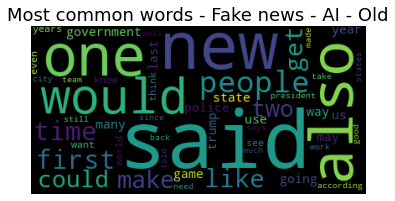

In [ ]:
# Compare old word cloud
ai_wordcloud = WordCloud(background_color="black", max_words=50).generate_from_frequencies(ai_cnt)
plt.imshow(ai_wordcloud)
plt.axis("off")
plt.title("Most common words - Fake news - AI - Old", fontsize=18)
plt.show()

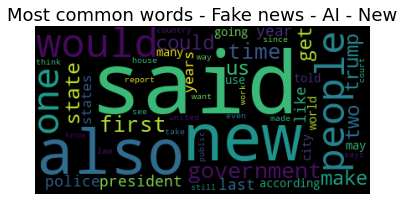

In [ ]:
# New ai word cloud

# Same process as before to generate word cloud
new_ai_text_list = list(articles_df.text[articles_df.group == "fake_ai"])
new_ai_word_list = [tokenize_text(article) for article in new_ai_text_list] 
new_flat_ai_word_list = [word for article in new_ai_word_list for word in article]

new_ai_cnt = Counter(new_flat_ai_word_list)

new_ai_wordcloud = WordCloud(background_color="black", max_words=50).generate_from_frequencies(new_ai_cnt)
plt.imshow(new_ai_wordcloud)
plt.axis("off")
plt.title("Most common words - Fake news - AI - New", fontsize=18)
plt.show()

## Sentiment Score 
Here we use the Afinn library to get a sentiment score for each article.

The library uses a wordlist to produce sentiment scores on a larger body of text. It's a fast and easy way to obtain text sentiment without training a ML model from scratch.

In [ ]:
!pip install afinn
from afinn import Afinn

In [ ]:
afinn = Afinn(language='en')

# Example of sentiment scores
print('Score for "I hate this and it sucks": ', afinn.score("I hate this and it sucks"))
print('Score for "I love it and it\'s great!": ', afinn.score("I love it and it's great!"))

Score for "I hate this and it sucks":  -6.0
Score for "I love it and it's great!":  6.0


In [ ]:
# Create sentiment column
articles_df['sentiment'] = articles_df.text.apply(lambda x: afinn.score(x))

### Visualizing sentiment

Text(0.5, 1.0, 'Sentiment by group')

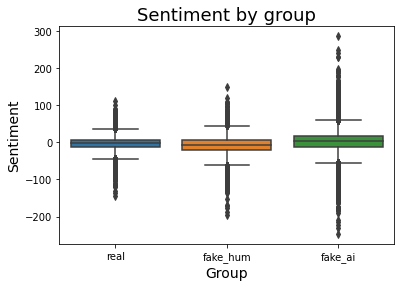

In [ ]:
sns.boxplot(x='group', y='sentiment', data=articles_df)

plt.xlabel("Group", fontsize= 14)
plt.ylabel("Sentiment", fontsize= 14)
plt.title("Sentiment by group", fontsize=18)

Looking at the plot above we can see:


*   As we move from left to right, the range of sentiment increases between groups.
*   The real articles have the smallest range of sentiment, and AI articles have the largest.
*   Median sentiment is the highest for the AI text. 



In [ ]:
# Final df
articles_df.head()

,text,group,length,sentences,words_per_sent,text_lower,sentiment
0,The head of a conservative Republican faction ...,real,4636,[The head of a conservative Republican faction...,24.700000,the head of a conservative republican faction ...,6.0
1,Transgender people will be allowed for the fir...,real,4054,[Transgender people will be allowed for the fi...,29.190476,transgender people will be allowed for the fir...,3.0
2,The special counsel investigation of links bet...,real,2766,[The special counsel investigation of links be...,26.882353,the special counsel investigation of links bet...,-9.0
3,Trump campaign adviser George Papadopoulos tol...,real,2431,[Trump campaign adviser George Papadopoulos to...,23.312500,trump campaign adviser george papadopoulos tol...,-15.0
4,President Donald Trump called on the U.S. Post...,real,5173,"[President Donald Trump called on the U.S., Po...",20.850000,president donald trump called on the u.s. post...,-15.0


## Revisualizing differences
Now that we have dropped a significant number of articles, we take a look at how this has impacted our data.

Text(0.5, 1.0, 'Article Length by Group')

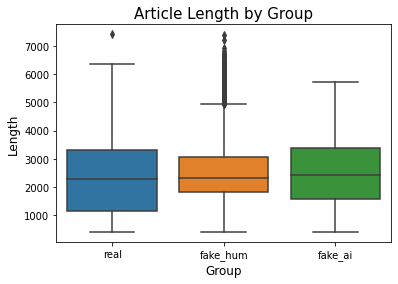

In [ ]:
# Viewing new article lengths after crops
sns.boxplot(x='group', y='length', data=articles_df)

plt.xlabel("Group", fontsize= 12)
plt.ylabel("Length", fontsize= 12)
plt.title("Article Length by Group", fontsize=15)

The average article length is now nearly identical between groups.

In [ ]:
# articles_df.describe()
print("Avg length - real: " + str(articles_df[articles_df['group']== 'real'].length.mean()))
print("Avg length - fake_hum: " + str(articles_df[articles_df['group']== 'fake_hum'].length.mean()))
print("Avg length - fake_ai: " + str(articles_df[articles_df['group']== 'fake_ai'].length.mean()))

Avg length - real: 2427.019217330538
Avg length - fake_hum: 2536.155209419268
Avg length - fake_ai: 2504.2294754870477


The average words per sentences between groups is also much more similar. **Now we are ready to run our ML models!**

Text(0.5, 1.0, 'Avg words per sentence by group')

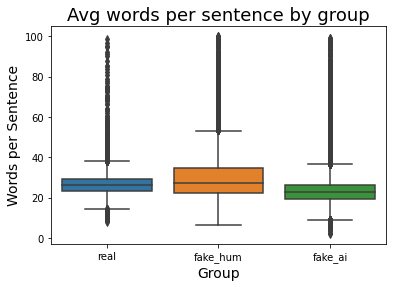

In [ ]:
sns.boxplot(x='group', y='words_per_sent', data=articles_df)

plt.xlabel("Group", fontsize= 14)
plt.ylabel("Words per Sentence", fontsize= 14)
plt.title("Avg words per sentence by group", fontsize=18)

# Machine Learning Models

**Testing:** Can GPT-2 generate fake news that is more difficult to detect than human-generated fake news.

We decided to split this part into two main components: Unsupervised and Supervised Learning.


1.   **Unsupervised Clustering Algorithm** - We utilized a k-means clustering algorithm with k = 3 in order to see how correlated the clusters the clustering algorithm assigned to our data was with the actual classes. We split this into two parts:

* (1) Clustering with Subset of Data
> We first clustered the principal components on a subset of the data for the sake of having a better visualization. When taking all the data into account, we had to utilize a sparse matrix (due to RAM limits) and Truncated SVD which made the visualizations less expressive.

* (2) Clustering on All Data
> Next, we clustered all of our data to yield the overall clustering. This clustering worked slightly differently. We used a different protocol for our dimensionality reduction and also inputted a sparse matrix.

More details are included in those cells.


2.   **Supervised Classification Algorithms** - We then decided to look into how well we could classify the articles as either fake, real, or AI. We did this by looking into three separate classification problems.


*   (1) Real vs. AI-Generated Articles 
> For this classification problem, we trained our data on the real articles and all the AI-generated articles. Our goal with this classification problem is to compare the results to the Real vs. Human-Generated to see which set of fake articles could "fool" our classifier more.


*   (2) Real vs. Human-Generated Fake Articles
> Like the previous classification problem, our goal was to compare the results of this algorithm to the other classification models to see what insight we could obtain. We trained our data on the real articles and the human-generated fake articles. When comparing the performances of the classification of (1) with (2), we will primarily be focusing on how they performed differently.

*   (3) Real vs. All Fake Articles
> This classification problem serves as our "baseline" where we try to see how well the real and fake articles can be classified as whole. If we notice that our classification models perform better than this baseline for a specific type of fake news (AI or human-generated) we will be able to conclude which dataset can be more easily classified as fake.

For each of these classification problems, we utilized a Logistic Regression and Support Vector Machines. One bottleneck we faced was having to utilize models that could work with sparse matricies. Unfortunately, Naive Bayes is not efficient with sparse features. More on why we chose Logit and SVM models specifically later.



## Clustering Part I - Subset of Data

**Pre-Processing**

Here we quickly define subsets of data that we will use to train and test our clustering and classification algorithms prior to transforming them into vectors. We split our data into different lists and vectors so that we can run the classification algorithm on different parts of our overall corpus.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances

real_text = articles_df[articles_df['group'] == "real"][['text','group']][:1000]
fake_text = articles_df[articles_df['group']=='fake_hum'][['text','group']][:500]
ai_text = articles_df[articles_df['group']=='fake_ai'][['text','group']][:500]

# Clustering
clustering_text_X = real_text['text'].append(fake_text['text']).append(ai_text['text'])

# Classification - Real vs. AI
# X = real_ai_text_X | y = real_ai_text_y
real_ai_text_X = real_text['text'][:500].append(ai_text['text'])
real_ai_text_y_raw = real_text['group'][:500].append(ai_text['group'])
real_ai_text_y = []
for val in real_ai_text_y_raw:
  if val == 'real':
    real_ai_text_y.append(0)
  else:
    real_ai_text_y.append(1)

# Classification - Real vs. Human
# X = real_human_text_X | y = real_human_text_y
real_human_text_X = real_text['text'][:500].append(fake_text['text'])
real_human_text_y_raw = real_text['group'][:500].append(fake_text['group'])
real_human_text_y = []
for val in real_human_text_y_raw:
  if val == 'real':
    real_human_text_y.append(0)
  else:
    real_human_text_y.append(1)

# Classification - Real vs. All Fake
# X = real_allfake_text_X | y = real_allfake_text_y
real_allfake_text_X = real_text['text'].append(fake_text['text']).append(ai_text['text'])
real_allfake_text_y_raw = real_text['group'].append(fake_text['group']).append(ai_text['group'])
real_allfake_text_y = []
real_allfake_text_clusters = []
for val in real_allfake_text_y_raw:
  if val == 'real':
    real_allfake_text_clusters.append(1)
    real_allfake_text_y.append(0)   
  elif val == 'fake_hum':
    real_allfake_text_clusters.append(2)
    real_allfake_text_y.append(1)
  else:
    real_allfake_text_clusters.append(0)
    real_allfake_text_y.append(1)


**Sklearn TF-IDF Vectorization for Clustering**

Using the data we pre-processed and split in the previous cell, we vectorized the data so that we can utilize the vectors in our clustering algorithm. Here, we made use of Sklearn's TF-IDF vectorization. We were able to utilize this because we used a subset of our data so did not have to worry about RAM issues. When we tried this with all of our data, we ran into memory issues and had to utilize a separate library and sparse matricies (more about this later on).

In [ ]:
tf_idf_vectorizor = TfidfVectorizer()
tf_idf = tf_idf_vectorizor.fit_transform(real_ai_text_X)
tf_idf_norm = normalize(tf_idf)
X_real_ai = tf_idf_norm.toarray()

tf_idf_vectorizor2 = TfidfVectorizer()
tf_idf2 = tf_idf_vectorizor2.fit_transform(real_human_text_X)
tf_idf_norm2 = normalize(tf_idf2)
X_real_human = tf_idf_norm2.toarray()

tf_idf_vectorizor3 = TfidfVectorizer()
tf_idf3 = tf_idf_vectorizor3.fit_transform(real_allfake_text_X)
tf_idf_norm3 = normalize(tf_idf3)
X_real_allfake = tf_idf_norm3.toarray()

**K-Means Clustering on Subset of Data using Principal Components**



Here we cluster our subset of data. We first reduce the dimensionality of our dataset using principal components in order to help visualize the clusters in two-dimensions. After looking at the visualization, we wanted to see how accurate the clusters the text was assigned to are with the actual classes.

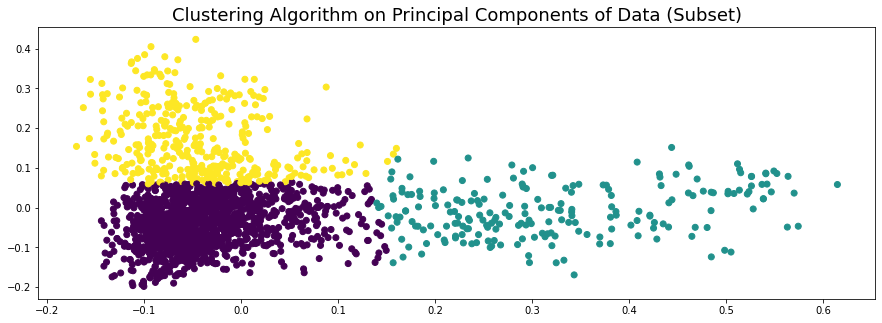

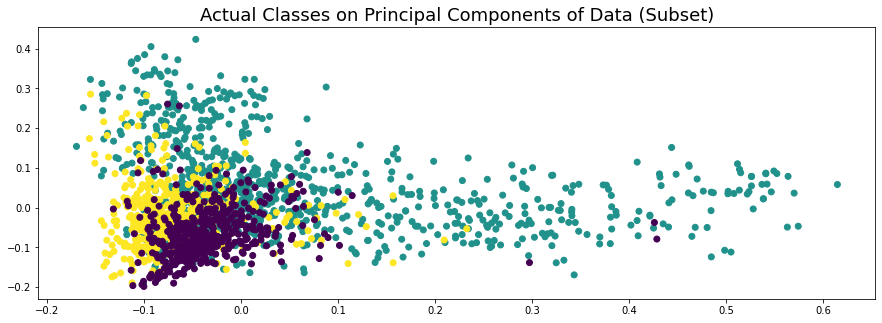

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(X_real_allfake)
kmeans = KMeans(n_clusters=3, max_iter=600, algorithm = 'auto')
fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

clustering_df = pd.DataFrame(Y_sklearn)
clustering_df.columns = ['x', 'y']
clustering_df['prediction'] = prediction

plt.scatter(Y_sklearn[:,0],Y_sklearn[:,1], c = prediction);
plt.title("Clustering Algorithm on Principal Components of Data (Subset)", size = 18)
plt.gcf().set_size_inches(15,5)

plt.figure()
plt.scatter(Y_sklearn[:,0],Y_sklearn[:,1], c = real_allfake_text_clusters);
plt.title("Actual Classes on Principal Components of Data (Subset)", size = 18)
plt.gcf().set_size_inches(15,5)

**K-Means Clustering Interpretation (Subset of Data)**

Our K-Means Clustering Algorithm was able to cluster the data into three main clusters. When comparing these clusters to the actual classes, it looks like it did a fairly good job of clustering the data into the three actual classes. There is some overlap with the yellow and purple, however, most of the data points to the right are all correctly clustered into a specific class.

This made us realize that if our clustering algorithm was this accurate, our classification algorithms should be well suited for classifying the data into groups.

## Clustering Part II - All Data

**Pre-Processing**

Here we quickly define subsets of data that we will use to train and test our clustering and classification algorithms prior to transforming them into vectors. 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances

# Limiting to 16,000 to control for different samples sizes between groups
real_text = articles_df[articles_df['group'] == "real"][['sentences','group']][:16000]
fake_text = articles_df[articles_df['group']=='fake_hum'][['sentences','group']][:16000]
ai_text = articles_df[articles_df['group']=='fake_ai'][['sentences','group']][:16000]

# Clustering
clustering_text_X = real_text['sentences'].append(fake_text['sentences']).append(ai_text['sentences'])

# Classification - Real vs. AI
# X = real_ai_text_X | y = real_ai_text_y
real_ai_text_X = real_text['sentences'].append(ai_text['sentences'])
real_ai_text_y_raw = real_text['group'].append(ai_text['group'])
real_ai_text_y = []
for val in real_ai_text_y_raw:
  if val == 'real':
    real_ai_text_y.append(0)
  else:
    real_ai_text_y.append(1)

# Classification - Real vs. Human
# X = real_human_text_X | y = real_human_text_y
real_human_text_X = real_text['sentences'].append(fake_text['sentences'])
real_human_text_y_raw = real_text['group'].append(fake_text['group'])
real_human_text_y = []
for val in real_human_text_y_raw:
  if val == 'real':
    real_human_text_y.append(0)
  else:
    real_human_text_y.append(1)

# Classification - Real vs. All Fake
# X = real_allfake_text_X | y = real_allfake_text_y
real_allfake_text_X = real_text['sentences'].append(fake_text['sentences'][:8000]).append(ai_text['sentences'][:10000])
real_allfake_text_y_raw = real_text['group'].append(fake_text['group'][:8000]).append(ai_text['group'][:10000])
real_allfake_text_y = []
real_allfake_text_clusters = []
for val in real_allfake_text_y_raw:
  if val == 'real':
    real_allfake_text_clusters.append(2)
    real_allfake_text_y.append(0)   
  elif val == 'fake_hum':
    real_allfake_text_clusters.append(0)
    real_allfake_text_y.append(1)
  else:
    real_allfake_text_clusters.append(1)
    real_allfake_text_y.append(1)


**Gensim TF_IDF Vectorization**

Using the data we pre-processed and split in the previous cell, we vectorized the data so that we can utilize the vectors in our machine learning models. We utilized the Gensim library because of how large our corpus was. This library allows us to utilize a sparse matrix rather than an array to hold our data, which helps optimize for memory.

In [ ]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from gensim.matutils import corpus2csc

real_ai_text_X_raw = Dictionary(real_ai_text_X)
real_allfake_text_X_raw = Dictionary(real_allfake_text_X)
real_human_text_X_raw = Dictionary(real_human_text_X)

real_ai_corpus = [real_ai_text_X_raw.doc2bow(line) for line in real_ai_text_X]
real_allfake_corpus = [real_allfake_text_X_raw.doc2bow(line) for line in real_allfake_text_X]
real_human_corpus = [real_human_text_X_raw.doc2bow(line) for line in real_human_text_X]

real_ai_model = TfidfModel(real_ai_corpus)
real_allfake_model = TfidfModel(real_allfake_corpus)
real_human_model = TfidfModel(real_human_corpus)

real_ai_vector = real_ai_model[real_ai_corpus]
real_allfake_vector = real_allfake_model[real_allfake_corpus]
real_human_vector = real_human_model[real_human_corpus]

real_ai_X = corpus2csc(real_ai_vector).T
real_allfake_X = corpus2csc(real_allfake_vector).T
real_human_X = corpus2csc(real_human_vector).T



**K-Means Clustering using Principal Components (All Data)**

Here we cluster our all of our data. We first reduce the dimensionality of our dataset using principal components in order to help visualize the clusters in two-dimensions. Unlike the last clustering where we utilized a plain-vanilla PCA, here we utilized a Truncated SVD due to having a sprase matrix. The truncated SVD differs by not standardizing the data to a centroid when finding principal components, making it efficient for sparse matricies.

Like before, after looking at the visualization, we wanted to see how accurate the clusters the text was assigned to are with the actual classes.

(Colors are arbitrary).

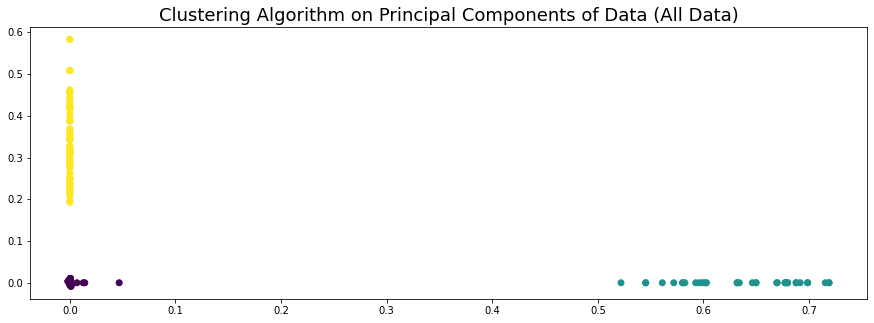

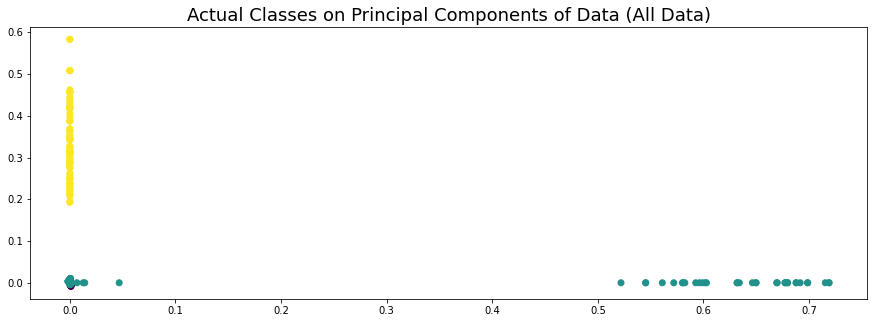

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

sklearn_pca = TruncatedSVD(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(real_allfake_X)
kmeans = KMeans(n_clusters=3, max_iter=600, algorithm = 'auto')
fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

clustering_df = pd.DataFrame(Y_sklearn)
clustering_df.columns = ['x', 'y']
clustering_df['prediction'] = prediction


plt.scatter(Y_sklearn[:,0],Y_sklearn[:,1], c = prediction);
plt.title("Clustering Algorithm on Principal Components of Data (All Data)", size = 18)
plt.gcf().set_size_inches(15,5)

plt.figure()
plt.scatter(Y_sklearn[:,0],Y_sklearn[:,1], c = real_allfake_text_clusters);
plt.title("Actual Classes on Principal Components of Data (All Data)", size = 18)
plt.gcf().set_size_inches(15,5)

plt.show()

**K-Means Clustering Interpretation (All of the Data)**

Our K-Means Clustering Algorithm was able to cluster the data into three main clusters like earlier. When comparing these clusters to the actual classes, it looks like it did a better job than when looking at the subset of the data. The clusters seem much more distinguishable and separated with much less overlap.


## Classification Algorithms

After seeing the robust performance of our clustering algorithm in distinguishing our three classes, we were fairly confident we would be able to classify our data well. In order to do this, we decided to utilize simple models, starting with a logistic regression. More on the models later.

**Logistic Regression**

First, we built a simple classification model for our data using a Logistic Regression. We train our model multiple times for each of our sub-problems.
We chose a logistic regression as our first model to obtain a "baseline" classification accuracy. Depending on the performance of this model, we would determine which models to use for the other classification problems.


**Logistic Regression (1) - Real News vs. AI News**





In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = real_ai_X
y = real_ai_text_y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LogisticRegression()
logit = lr.fit(X_train,y_train)
y_predict = logit.predict(X_test)


print("Accuracy: ", logit.score(X, y)*100,"%")

Accuracy:  92.09375 %


**Logistic Regression (2) - Real News vs. Human Fake News**



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = real_human_X
y = real_human_text_y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

lr = LogisticRegression()
logit = lr.fit(X_train,y_train)
y_predict = logit.predict(X_test)

print("Accuracy: ", logit.score(X, y)*100,"%")

Accuracy:  93.1875 %


**Logistic Regression (3) - Real News vs. All Fake News**



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = real_allfake_X
y = real_allfake_text_y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LogisticRegression()
logit = lr.fit(X_train,y_train)
y_predict = logit.predict(X_test)

print("Accuracy: ", logit.score(X, y)*100,"%")

Accuracy:  91.2235294117647 %


**Logistic Regression Interpretation**

Our Logit model was able to obtain around a 90-93% accuracy in classifying our data. With such a high accuracy, we realized that utilizing more complex models such as a neural network would not be worth the added complexity. Using an ANN would increase the likelihood of overfitting our data and would not be worth the extra computational inefficiency.

**Support Vector Machine (SVM) - Support Vector Classifier (SVC)**

After running the logistic regressions, we started looking into how other models would perform. Here we tried out an SVM (SVC). We utilized an SVM because it is one of the more commonly used classification algorithms as well as because when looking at the clusters of our data, we noticed that clusters were quite distinguishable. This separation led us to believe that utilizing support vectors would be robust in classififying our data due to the large separation between the clusters, something the SVM optimizes for.

**SVM (1) - Real News vs. AI News**

In [ ]:
from sklearn.svm import SVC

X = real_ai_X
y = real_ai_text_y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svc = SVC()
svm = svc.fit(X_train,y_train)
y_predict = svm.predict(X_test)

print("Accuracy: ", svm.score(X, y)*100,"%")

Accuracy:  90.48125 %


**SVM (2) - Real News vs. Human Fake News**

In [ ]:
from sklearn.svm import SVC

X = real_human_X
y = real_human_text_y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


svc = SVC()
svm = svc.fit(X_train,y_train)
y_predict = svm.predict(X_test)

print("Accuracy: ", svm.score(X, y)*100,"%")

Accuracy:  91.15625 %


**SVM (3) - Real News vs. All Fake News**

In [ ]:
from sklearn.svm import SVC

X = real_allfake_X
y = real_allfake_text_y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


svc = SVC()
svm = svc.fit(X_train,y_train)
y_predict = svm.predict(X_test)

print("Accuracy: ", svm.score(X, y)*100,"%")

Accuracy:  91.01470588235294 %


**SVM Interpretation**

Surprisingly, our SVM performed about as well as our logistic regression. This was unexpected because when looking at the clusters of our data, we saw clearly distinguishable clusters and expected the SVM to take advantage of that. Regardless, the algorithm performed well but took longer than the logistic regression. This made us believe that the logistic regression, when taking model complexity, accuracy, and computational efficiency into account, is more useful than an SVM for our data.

# Interpretation and Conclusion

### **Results**

At first, when we ran our models we noticed that we had unreasonably high accuracies. This made us realize that a lot of our data was not pre-processed fully since our model was obtaining near 100% accuracy while only being trained on a small subset of the data. We looked back to the EDA and noticed some features were very distinguishable between the different classes (avg. words per sentence, article lengths, news-content). We normalized for these features and were able to successfully remove those factors.

Our first step in modeling was to represent our text data in a vector space. We did this by using a TF-IDF vectorizer and creating a sparse matrix of our features. We were able to develop around 650,000 features and ran them through our models. When executing the k-means clustering algorithm, we set k=3 to see how well the clusters the unsupervised algorithm found correlated with the actual classes. When doing this, we noticed that the clusters were fairly accurate and thus believed that our classification models would also be accurate.

We used a logistic regression first to obtain a baseline accuracy. That accuracy was around 90%-93% for all three of our sub-problems. We ran an SVM after expecting the accuracy to be higher. We expected this because an SVM is more complex and when we looked at the clusters of our principal components, we noticed distinguishable centroids and thus thought an SVM would be able to capitalize on this by finding support vectors that maximize the distance between the two clusters. In the end, the accuracies stayed around the same for both.

###**Conclusion**

Our models were able to classify real vs. human-authored fake articles with around the same accuracy as real vs. AI-generated articles. We concluded that once normalized for features like article length and vocabulary, the fake articles and AI-generated articles are equally difficult to distinguish.


###**Limitations, Challenges, Next Steps**

Overall we are pleased with how well our model performed in classifying both human-authored and AI-generated fake news. Despite this success, our experiment faced some limitations. 

For the AI-generated text dataset we used, a large number of samples contained non-news related content. By generating features from the text and finding differences between groups (such as average number of words per sentence and most common words in a group) we were able to apply filters that made our corpus of AI text significantly more news-oriented. Even though this resulted in a corpus that was much harder to distinguish from real news articles, future experiments would benefit from testing on AI-text datasets strictly limited to news content.

Furthermore, our interest is in testing how well the most sophisticated AI-generated fake news can evade detection compared to it's human-authored counterpart. Since GPT-3 has surpassed GPT-2 as the most sophisticated Natural Language Generation model, future experiments should run this test using GPT-3 outputs.

Another limitation of our project was the small number of source's used in gathering the Real news data subset. An overwhelming majority of articles were from Reuters. This may have contributed to our high classification accuracy -- one can imagine that Reuter's articles follow a particular format, as many news organizations have their own idiosyncratic writing styles. Gathering more real and fake news data from a broader set of sources would strengthen future experiments.

A final limitation to note was our inability to test certain types of models. Due to the number of number of samples we had and limited RAM, we were unable to vectorize the text into a dense matrix format without running out of memory. This prevented us from testing models that use dense matrices such as a Naive Bayes. To resolve this issue, we used a sparse matrix.